In [1]:
import librosa
import numpy as np
import matplotlib.pyplot as plt 
import seaborn
%matplotlib inline
seaborn.set()

In [202]:
import pandas as pd

In [415]:
def phase_anchor(data, axis=-1):
    '''Multi-dimensional phase anchoring
    
    Given a mult-dimensional patch and an axis along which to apply an FFT,
    
    Parameters
    ----------
    data : np.ndarray, dtype=float
        The input data
        
    axis : int
        The axis along which to compute the FFT
        
    Returns
    -------
    data_aligned : np.ndarray like data
        data with each frame aligned to the first
    '''
    
    F = np.fft.rfft(data, axis=axis)
    
    mag = np.abs(F)
    phase = np.angle(F)
    
    # Select the reference phase value
    anchor_idx = [0] * F.ndim
    anchor_idx[axis] = 1
    angle = phase[tuple(anchor_idx)]
    
    # Compute phase shifts for each bin
    phase_idx = [slice(None)] * F.ndim
    phase_idx[axis] = slice(1, None)
    shift = angle * np.arange(1, F.shape[axis])
    
    # This indexing will reshape shift to be broadcast-compatible with phase
    shift_idx = [np.newaxis] * F.ndim
    shift_idx[axis] = slice(None)
    phase[phase_idx] = phase[phase_idx] - shift[shift_idx]
    
    # Combine the magnitudes with our new phase
    F2 = mag * np.exp(1.j * phase)
    
    return np.fft.irfft(F2, axis=axis)

In [163]:
files = librosa.util.find_files('/home/bmcfee/data/beatles_iso/audio/', ext='flac')

In [165]:
files[32]

"/home/bmcfee/data/beatles_iso/audio/The Beatles/03_-_A_Hard_Day's_Night/05_-_And_I_Love_Her.flac"

In [200]:
labfiles = librosa.util.find_files('/home/bmcfee/data/beatles_iso/seglab_tut/', ext='lab')

In [205]:
segments = pd.read_table(labfiles[32], header=None, sep=' ')

In [166]:
y, sr = librosa.load(files[32])

In [272]:
cqgram = librosa.cqt(y, sr=sr)

In [273]:
tempo, beats = librosa.beat.beat_track(y=y, sr=sr)

In [274]:
subseg = librosa.segment.subsegment(cqgram, beats)

In [275]:
segment_frames = librosa.time_to_frames(segments[0].values)

In [277]:
zip( librosa.util.match_events(segment_frames, subseg), segments[0], segments[1], segments[2])

[(0, 0.0, 9.6107333000000015, 'Intro'),
 (74, 9.6107333000000015, 29.8779273, 'Verse'),
 (231, 29.8779273, 50.692883299999998, 'Verse'),
 (390, 50.692883299999998, 67.673505300000002, 'Bridge'),
 (519, 67.673505300000002, 88.787240499999996, 'Verse'),
 (679, 88.787240499999996, 110.0005689, 'VerseS'),
 (839, 110.0005689, 131.16410070000001, 'Verse'),
 (998, 131.16410070000001, 148.1090815, 'Outro')]

In [278]:
cqb = librosa.feature.sync(cqgram, subseg, aggregate=np.median)

In [408]:
patch = cqb[:, 519:536]

In [409]:
p2 = phase_anchor(patch, axis=0)

In [410]:
# Generate a synthetically pitch-shifted patch
patch_shift = np.roll(patch, 11, axis=0)
#patch_shift = cqb[:, 838:855]

In [411]:
p3 = phase_anchor(patch_shift, axis=0)

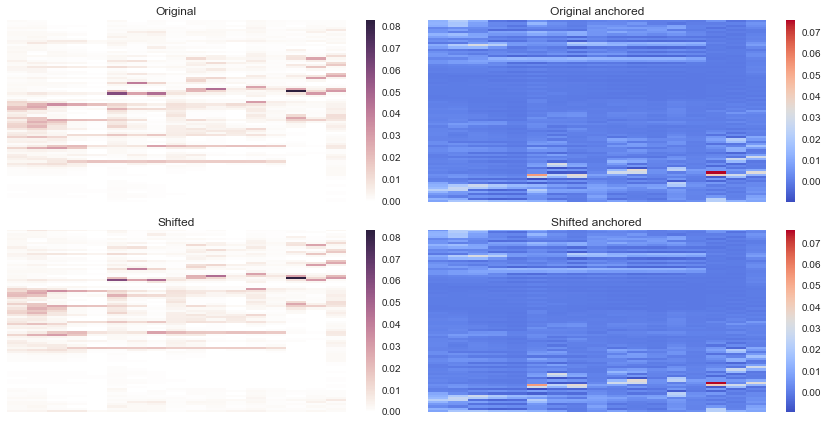

In [416]:
plt.figure(figsize=(12,6))
plt.subplot(2,2,1)
librosa.display.specshow(patch)
plt.title('Original')
plt.colorbar()
plt.subplot(2,2,2)
librosa.display.specshow(p2)
plt.title('Original anchored')
plt.colorbar()
plt.subplot(2,2,3)
librosa.display.specshow(patch_shift)
plt.title('Shifted')
plt.colorbar()
plt.subplot(2,2,4)
librosa.display.specshow(p3)
plt.title('Shifted anchored')
plt.colorbar()
plt.tight_layout()

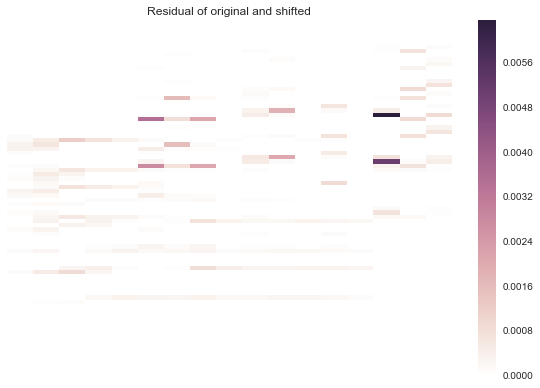

In [417]:
librosa.display.specshow(np.abs(patch - patch_shift)**2)
plt.title('Residual of original and shifted')
plt.colorbar()
plt.tight_layout()

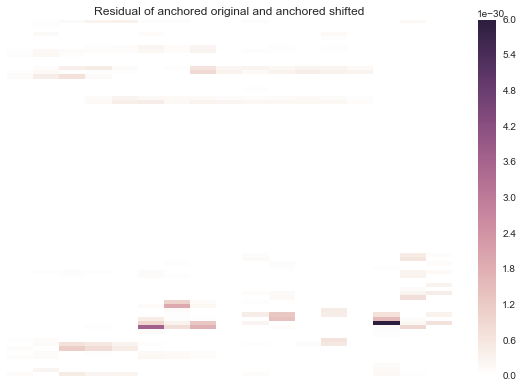

In [418]:
mpld3.disable_notebook()
librosa.display.specshow(np.abs(p2 - p3)**2)
plt.title('Residual of anchored original and anchored shifted')
plt.colorbar()
plt.tight_layout()